## Set Up

In [139]:
import pandas as pd
import calendar
import datetime

## Import Data

In [140]:
# Create function to import multiple data files

data_path = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"

def import_data(date):
    """
    import data
    clean column names
    """
    dfname = pd.read_csv(data_path+date+".txt")
    dfname.columns = dfname.columns.str.strip()
    return dfname
          
mta190504_raw = import_data("190504")
mta190511_raw = import_data("190511")
mta190518_raw = import_data("190518")
mta190525_raw = import_data("190525")
mta190601_raw = import_data("190601")


In [141]:
# Concatenate all data
frames = [mta190504_raw, mta190511_raw, mta190518_raw, mta190525_raw, mta190601_raw]

mta19_raw = pd.concat(frames).reset_index().drop(["index"], axis=1)

mta19_raw.info()
mta19_raw.describe()
#mta19_raw.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026784 entries, 0 to 1026783
Data columns (total 11 columns):
C/A         1026784 non-null object
UNIT        1026784 non-null object
SCP         1026784 non-null object
STATION     1026784 non-null object
LINENAME    1026784 non-null object
DIVISION    1026784 non-null object
DATE        1026784 non-null object
TIME        1026784 non-null object
DESC        1026784 non-null object
ENTRIES     1026784 non-null int64
EXITS       1026784 non-null int64
dtypes: int64(2), object(9)
memory usage: 86.2+ MB


,ENTRIES,EXITS
count,1.026784e+06,1.026784e+06
mean,4.154868e+07,3.402282e+07
std,2.116724e+08,1.949751e+08
min,0.000000e+00,0.000000e+00
25%,3.525555e+05,1.442150e+05
50%,2.174353e+06,1.245738e+06
75%,6.789071e+06,4.603742e+06
max,2.129343e+09,2.124127e+09


In [142]:
def time_interval(x):
    if x in [0,1,2,3]:
        return "20:00-23:59"
    elif x in [4,5,6,7]:
        return "00:00-03:59"
    elif x in [8,9,10,11]:
        return "04:00-07:59"
    elif x in [12,13,14,15]:
        return "08:00-11:59"
    elif x in [16,17,18,19]:
        return "12:00-15:59"
    elif x in [20,21,22,23]:
        return "16:00-19:59"

In [143]:
# Add and format new variables

def data_clean(dfname):
    """
    add and format new variables
    """
    dfname2 = dfname.copy()
    # Create variables:
    # "time_hour" that simplifies the hour for later grouping purposes
    dfname2["time_hour"] = pd.to_numeric(dfname2["TIME"].str[0:2])
    # formatted date variable "DDATE"
    dfname2['DDATE']=[datetime.datetime.strptime(x, '%m/%d/%Y') for x in dfname2['DATE']]
    # formatted time variable "DTIME"
    dfname2['DTIME']=[datetime.datetime.strptime(x, '%H:%M:%S') for x in dfname2['TIME']]
    dfname2['DDATETIME'] = pd.to_datetime(dfname2['DATE']+" "+dfname2['TIME'])
    #dfname2['DDATETIME2'] = dfname2['DDATETIME'] - datetime.timedelta(seconds=1)
    dfname2['DTIME']=[format(x,"%H:%M:%S") for x in dfname2['DTIME']]
    # formatted day of the week variable "DDAY"
    dfname2['DDAY']=[calendar.day_name[datetime.datetime.weekday(x)] for x in dfname2['DDATE']]
    # create time period category "time_cat"
    dfname2["time_cat"] = dfname2["time_hour"].apply(time_interval)
    
    #INVESTIGATION
#     dfname2["time_cat2"] = dfname2["time_hour2"].apply(time_interval)
#     dfname2['new_date'] = dfname2['DDATETIME2'] - datetime.timedelta(seconds=1)
#     dfname2['new_time'] = dfname2['DDATETIME'] - datetime.timedelta(seconds=1)
#     dfname2["time_hour2"] = pd.to_numeric(dfname2["TIME"].str[0:2])
    
    # Sort before grouping for difference calculating
    dfname2.sort_values(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION","DATE","TIME","DESC"], inplace = True)
    # Create difference columns to calculate difference in entries and exits between the row and the row before (aka the time before)
    dfname2["entries_diff"] = dfname2.groupby(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION"]).ENTRIES.diff()
    dfname2["exits_diff"] = dfname2.groupby(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION"]).EXITS.diff()
    dfname2["entries-exits"] = dfname2["entries_diff"] - dfname2["exits_diff"]
    dfname2["entries+exits"] = dfname2["entries_diff"] + dfname2["exits_diff"]
    
    # PLACEHOLDER Create better flag for suspiciously high differences in exits and entries diff
    
    #keep only rows with positive entries_diff, exits_diff, and ENTRIES
    dfname2= dfname2[dfname2.entries_diff > 0]
    dfname2 = dfname2[dfname2.exits_diff > 0]
    dfname2 = dfname2[dfname2.ENTRIES > 0]
    # dropping turnstile 00-04-00 at 23rd st due to data anomaly
    dfname2 = dfname2[(dfname2["STATION"] != "TWENTY THIRD ST") & (dfname2["SCP"] != "00-04-00")]
    dfname2 = dfname2[(dfname2["STATION"] != "23 ST") & (dfname2["DATE"] != "2019-05-11") & (dfname2["TIME"] != "00:00:00")]
    # exclude high entries and exits that are likely a result of a terminal reset
    dfname2 = dfname2[dfname2.entries_diff < 100000]
    dfname2 = dfname2[dfname2.exits_diff < 100000].reset_index().drop(["index"],axis=1)
    #dfname2 = dfname2[dfname2.entries_diff < 10**7]
    #dfname2 = dfname2[dfname2.exits_diff < 10**7].reset_index().drop(["index"],axis=1)
    return dfname2

mta19 = data_clean(mta19_raw)
#data_clean(mta18_raw, mta18)
#etc. - can run it for multiple years

In [144]:
mta19.info()
mta19.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749956 entries, 0 to 749955
Data columns (total 21 columns):
C/A              749956 non-null object
UNIT             749956 non-null object
SCP              749956 non-null object
STATION          749956 non-null object
LINENAME         749956 non-null object
DIVISION         749956 non-null object
DATE             749956 non-null object
TIME             749956 non-null object
DESC             749956 non-null object
ENTRIES          749956 non-null int64
EXITS            749956 non-null int64
time_hour        749956 non-null int64
DDATE            749956 non-null datetime64[ns]
DTIME            749956 non-null object
DDATETIME        749956 non-null datetime64[ns]
DDAY             749956 non-null object
time_cat         749956 non-null object
entries_diff     749956 non-null float64
exits_diff       749956 non-null float64
entries-exits    749956 non-null float64
entries+exits    749956 non-null float64
dtypes: datetime64[ns](2), float

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,time_hour,DDATE,DTIME,DDATETIME,DDAY,time_cat,entries_diff,exits_diff,entries-exits,entries+exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,...,4,2019-04-27,04:00:00,2019-04-27 04:00:00,Saturday,00:00-03:59,20.0,7.0,13.0,27.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,...,8,2019-04-27,08:00:00,2019-04-27 08:00:00,Saturday,04:00-07:59,23.0,35.0,-12.0,58.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,...,12,2019-04-27,12:00:00,2019-04-27 12:00:00,Saturday,08:00-11:59,100.0,76.0,24.0,176.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,...,16,2019-04-27,16:00:00,2019-04-27 16:00:00,Saturday,12:00-15:59,259.0,69.0,190.0,328.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,20:00:00,REGULAR,7035930,...,20,2019-04-27,20:00:00,2019-04-27 20:00:00,Saturday,16:00-19:59,279.0,50.0,229.0,329.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,04:00:00,REGULAR,7036119,...,4,2019-04-28,04:00:00,2019-04-28 04:00:00,Sunday,00:00-03:59,19.0,1.0,18.0,20.0
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,08:00:00,REGULAR,7036125,...,8,2019-04-28,08:00:00,2019-04-28 08:00:00,Sunday,04:00-07:59,6.0,15.0,-9.0,21.0
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,12:00:00,REGULAR,7036197,...,12,2019-04-28,12:00:00,2019-04-28 12:00:00,Sunday,08:00-11:59,72.0,52.0,20.0,124.0
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,16:00:00,REGULAR,7036372,...,16,2019-04-28,16:00:00,2019-04-28 16:00:00,Sunday,12:00-15:59,175.0,43.0,132.0,218.0
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,20:00:00,REGULAR,7036621,...,20,2019-04-28,20:00:00,2019-04-28 20:00:00,Sunday,16:00-19:59,249.0,42.0,207.0,291.0


In [145]:
mta19.describe()

,ENTRIES,EXITS,time_hour,entries_diff,exits_diff,entries-exits,entries+exits
count,7.499560e+05,7.499560e+05,749956.000000,749956.000000,749956.000000,749956.000000,749956.000000
mean,2.634331e+07,1.943462e+07,11.750744,213.145871,165.940834,47.205037,379.086705
std,1.543830e+08,1.305644e+08,6.244239,300.819084,277.590340,327.340752,477.435932
min,2.000000e+00,1.000000e+00,0.000000,1.000000,1.000000,-12816.000000,2.000000
25%,6.538268e+05,3.639438e+05,8.000000,29.000000,24.000000,-40.000000,79.000000
50%,2.726154e+06,1.612786e+06,12.000000,116.000000,78.000000,11.000000,247.000000
75%,6.949290e+06,4.995094e+06,17.000000,295.000000,203.000000,135.000000,541.000000
max,2.115843e+09,2.037865e+09,23.000000,73060.000000,51276.000000,37570.000000,108550.000000


In [146]:
import matplotlib.pyplot as plt
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

In [147]:
# Group by station, day of week, and date
mta_station_day = mta19.groupby(["STATION","DDAY","DDATE"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].sum().sort_values(["STATION","entries+exits"], ascending=False)
mta_station_day.head(10)

,STATION,DDAY,DDATE,entries_diff,exits_diff,entries+exits,entries-exits
12975,ZEREGA AV,Wednesday,2019-05-08,2931.0,2731.0,5662.0,200.0
12965,ZEREGA AV,Thursday,2019-05-09,2994.0,2625.0,5619.0,369.0
12974,ZEREGA AV,Wednesday,2019-05-01,2900.0,2700.0,5600.0,200.0
12977,ZEREGA AV,Wednesday,2019-05-22,2872.0,2700.0,5572.0,172.0
12978,ZEREGA AV,Wednesday,2019-05-29,2824.0,2736.0,5560.0,88.0
12968,ZEREGA AV,Thursday,2019-05-30,2829.0,2702.0,5531.0,127.0
12964,ZEREGA AV,Thursday,2019-05-02,2917.0,2582.0,5499.0,335.0
12970,ZEREGA AV,Tuesday,2019-05-07,2841.0,2640.0,5481.0,201.0
12971,ZEREGA AV,Tuesday,2019-05-14,2830.0,2639.0,5469.0,191.0
12972,ZEREGA AV,Tuesday,2019-05-21,2856.0,2611.0,5467.0,245.0


In [148]:
mta_station_dayavg = mta_station_day.groupby(["STATION"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].mean().sort_values(["entries+exits"], ascending=[True])
mta_station_dayavg.tail(10)

,STATION,entries_diff,exits_diff,entries+exits,entries-exits
171,CANAL ST,58692.742857,50274.428571,108967.171429,8418.314286
9,125 ST,62039.942857,51500.342857,113540.285714,10539.600000
109,86 ST,66134.485714,61598.257143,127732.742857,4536.228571
67,42 ST-PORT AUTH,76152.600000,63786.057143,139938.657143,12366.542857
351,TIMES SQ-42 ST,69628.200000,74510.542857,144138.742857,-4882.342857
224,FULTON ST,81775.228571,68437.285714,150212.514286,13337.942857
58,34 ST-HERALD SQ,85806.514286,87089.342857,172895.857143,-1282.828571
14,14 ST-UNION SQ,91151.800000,84337.457143,175489.257143,6814.342857
231,GRD CNTRL-42 ST,117435.514286,103496.514286,220932.028571,13939.000000
60,34 ST-PENN STA,133536.800000,123136.171429,256672.971429,10400.628571


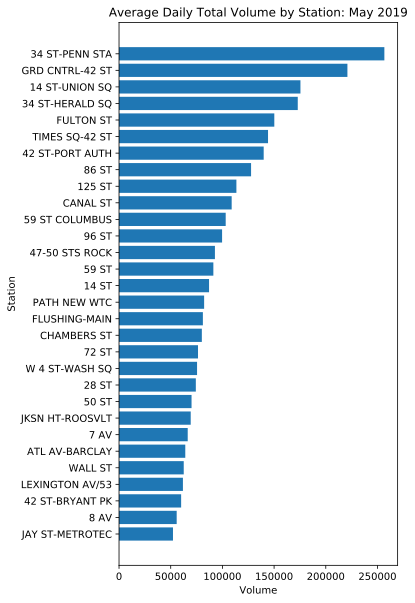

In [149]:
# GRAPH 1
#Plot graph of total volume
plt.figure(figsize = [5,10])
plt.barh(mta_station_dayavg["STATION"][-30:],mta_station_dayavg["entries+exits"][-30:])
plt.title("Average Daily Total Volume by Station: May 2019")
plt.ylabel("Station")
plt.xlabel("Volume");


In [150]:
def day_sort(x):
    if x == "Sunday":
        return 1
    elif x == "Monday":
        return 2
    elif x == "Tuesday":
        return 3
    elif x == "Wednesday":
        return 4
    elif x == "Thursday":
        return 5
    elif x == "Friday":
        return 6
    elif x == "Saturday":
        return 7

In [151]:
#GRAPH 2
mta_station_weekdayavg = mta_station_day.groupby(["STATION","DDAY"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].mean().sort_values(["entries+exits"], ascending=[True])

mta_station_weekdayavg["day_sort"] = mta_station_weekdayavg["DDAY"].apply(day_sort)

mta_station_weekdayavg.head(10)

,STATION,DDAY,entries_diff,exits_diff,entries+exits,entries-exits,day_sort
2153,ORCHARD BEACH,Wednesday,1.000000,1.00,2.000000,0.000000,4
2149,ORCHARD BEACH,Monday,1.000000,2.00,3.000000,-1.000000,2
2152,ORCHARD BEACH,Thursday,1.000000,2.00,3.000000,-1.000000,5
2151,ORCHARD BEACH,Sunday,10.000000,25.00,35.000000,-15.000000,1
2396,ST. GEORGE,Thursday,33.500000,3.00,36.500000,30.500000,5
2397,ST. GEORGE,Tuesday,38.500000,1.00,39.500000,37.500000,3
2394,ST. GEORGE,Saturday,38.750000,2.25,41.000000,36.500000,7
2150,ORCHARD BEACH,Saturday,18.000000,24.00,42.000000,-6.000000,7
2395,ST. GEORGE,Sunday,65.333333,4.00,69.333333,61.333333,1
2393,ST. GEORGE,Monday,93.000000,4.00,97.000000,89.000000,2


In [152]:
mta_34PE= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='34 ST-PENN STA' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_GC42= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='GRD CNTRL-42 ST' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_34HE= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='34 ST-HERALD SQ' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_14UN= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='14 ST-UNION SQ' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_23ST= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='23 ST' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_23ST

,STATION,DDAY,entries_diff,exits_diff,entries+exits,entries-exits,day_sort


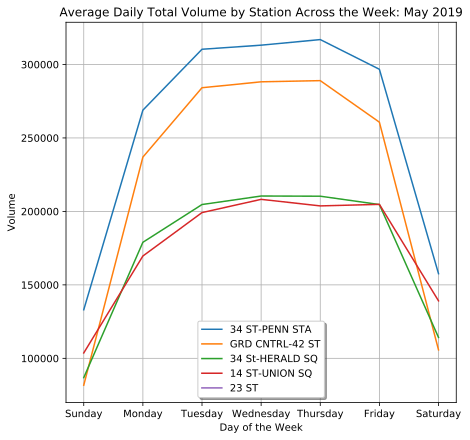

In [153]:

#figure canNOT be the (sum per day)/#time entries because the number time entries  taken per day is not the same
#therefore to inform on the traffic in the week, need to use full volume per day
#seems the WEDNESDAY is the most busy day in general
plt.figure(figsize = [7,7])
plt.grid()
plt.plot(mta_34PE['DDAY'],mta_34PE['entries+exits'])
plt.plot(mta_GC42['DDAY'],mta_GC42['entries+exits'])
plt.plot(mta_34HE['DDAY'],mta_34HE['entries+exits'])
plt.plot(mta_14UN['DDAY'],mta_14UN['entries+exits'])
plt.plot(mta_23ST['DDAY'],mta_23ST['entries+exits'])
plt.legend(["34 ST-PENN STA","GRD CNTRL-42 ST","34 St-HERALD SQ","14 ST-UNION SQ","23 ST"], shadow = True)
plt.title("Average Daily Total Volume by Station Across the Week: May 2019")
plt.ylabel("Volume")
plt.xlabel("Day of the Week");

In [154]:
# mta_34PE_time = mta_34PE.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_GC42_time = mta_GC42.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_34HE_time = mta_34HE.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_14UN_time = mta_14UN.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_TS42_time = mta_TS42.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_34PE_time

In [155]:
# Group by station, day of week, date, time_cat
mta_station_day_time = mta19.groupby(["STATION","DDAY","DDATE","time_cat"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].sum().sort_values(["STATION","entries+exits"], ascending=False)
mta_station_day_time.head(10)

,STATION,DDAY,DDATE,time_cat,entries_diff,exits_diff,entries+exits,entries-exits
70957,ZEREGA AV,Wednesday,2019-05-08,04:00-07:59,1272.0,553.0,1825.0,719.0
70951,ZEREGA AV,Wednesday,2019-05-01,04:00-07:59,1274.0,532.0,1806.0,742.0
70969,ZEREGA AV,Wednesday,2019-05-22,04:00-07:59,1271.0,520.0,1791.0,751.0
70897,ZEREGA AV,Thursday,2019-05-09,04:00-07:59,1269.0,516.0,1785.0,753.0
70808,ZEREGA AV,Monday,2019-05-06,04:00-07:59,1247.0,529.0,1776.0,718.0
70802,ZEREGA AV,Monday,2019-04-29,04:00-07:59,1243.0,524.0,1767.0,719.0
70939,ZEREGA AV,Tuesday,2019-05-21,04:00-07:59,1254.0,513.0,1767.0,741.0
70903,ZEREGA AV,Thursday,2019-05-16,04:00-07:59,1233.0,524.0,1757.0,709.0
70927,ZEREGA AV,Tuesday,2019-05-07,04:00-07:59,1244.0,511.0,1755.0,733.0
70891,ZEREGA AV,Thursday,2019-05-02,04:00-07:59,1264.0,481.0,1745.0,783.0


In [156]:
mta_station_day_timeavg = mta_station_day_time.groupby(["STATION","DDAY","time_cat"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].mean().sort_values(["STATION","entries+exits"], ascending=False)
mta_station_day_timeavg

,STATION,DDAY,time_cat,entries_diff,exits_diff,entries+exits,entries-exits
14483,ZEREGA AV,Wednesday,04:00-07:59,1249.80,523.0,1772.80,726.80
14471,ZEREGA AV,Thursday,04:00-07:59,1233.60,510.2,1743.80,723.40
14477,ZEREGA AV,Tuesday,04:00-07:59,1220.60,509.8,1730.40,710.80
14447,ZEREGA AV,Friday,04:00-07:59,1115.80,465.8,1581.60,650.00
14453,ZEREGA AV,Monday,04:00-07:59,1026.40,425.4,1451.80,601.00
14479,ZEREGA AV,Tuesday,12:00-15:59,620.80,635.8,1256.60,-15.00
14485,ZEREGA AV,Wednesday,12:00-15:59,576.40,667.2,1243.60,-90.80
14473,ZEREGA AV,Thursday,12:00-15:59,600.20,636.0,1236.20,-35.80
14449,ZEREGA AV,Friday,12:00-15:59,564.00,640.6,1204.60,-76.60
14486,ZEREGA AV,Wednesday,16:00-19:59,343.80,828.6,1172.40,-484.80


In [157]:
def select_station(station):
    new_data = mta_station_day_timeavg[(mta_station_day_timeavg["STATION"] == station) & (mta_station_day_timeavg["DDAY"] == "Wednesday")].sort_values(["DDAY","time_cat","entries+exits"])
    return new_data

mta_34PE_time_Wed = select_station("34 ST-PENN STA")
mta_GC42_time_Wed = select_station("GRD CNTRL-42 ST")
mta_34HE_time_Wed = select_station("34 ST-HERALD SQ")
mta_14UN_time_Wed = select_station("14 ST-UNION SQ")
mta_23ST_time_Wed = select_station("23 ST")

mta_23ST_time_Wed

,STATION,DDAY,time_cat,entries_diff,exits_diff,entries+exits,entries-exits


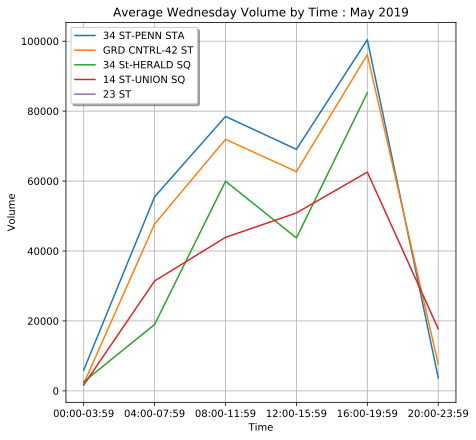

In [158]:
plt.figure(figsize = [7,7])
plt.grid()
plt.plot(mta_34PE_time_Wed['time_cat'],mta_34PE_time_Wed['entries+exits'])
plt.plot(mta_GC42_time_Wed['time_cat'],mta_GC42_time_Wed['entries+exits'])
plt.plot(mta_34HE_time_Wed['time_cat'],mta_34HE_time_Wed['entries+exits'])
plt.plot(mta_14UN_time_Wed['time_cat'],mta_14UN_time_Wed['entries+exits'])
plt.plot(mta_23ST_time_Wed['time_cat'],mta_23ST_time_Wed['entries+exits'])
plt.title("Average Wednesday Volume by Time : May 2019")
plt.legend(["34 ST-PENN STA","GRD CNTRL-42 ST","34 St-HERALD SQ","14 ST-UNION SQ","23 ST"], shadow = True)
plt.ylabel("Volume")
plt.xlabel("Time");

## Graphs

In [159]:
# "34 ST-PENN STA")
#mta_GC42_3 = select_station("GRD CNTRL-42 ST")
#mta_34HE_3 = select_station("34 ST-HERALD SQ")
#mta_14UN_3 = select_station("14 ST-UNION SQ")
#mta_23ST_3 = select_station("23 ST")
def select_station2(station):
    new_data = mta19.groupby(['STATION','DDAY','time_cat'],as_index=False)['entries+exits'].mean()
    new_data = new_data.loc[new_data["STATION"] == station]
    #new_data = mta_station_day_timeavg[(mta_station_day_timeavg["STATION"] == station) & (mta_station_day_timeavg["DDAY"] == "Wednesday")].sort_values(["DDAY","time_cat","entries+exits"])
    return new_data

mta_GC42_3 = select_station2("GRD CNTRL-42 ST")
mta_34PE_3 = select_station2("34 ST-PENN STA")
mta_34HE_3 = select_station2("34 ST-HERALD SQ")
mta_14UN_3 = select_station2("14 ST-UNION SQ")
mta_23ST_3 = select_station2("23 ST")

# mean_entries_exit = mta19.groupby(['STATION','DDAY','time_cat'])['entries+exits'].mean()
# m = mean_entries_exit['GRD CNTRL-42 ST']
# m1=m.to_frame().reset_index()
# m1.head()


KeyError: 'Monday'

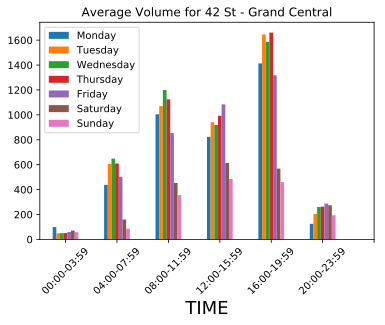

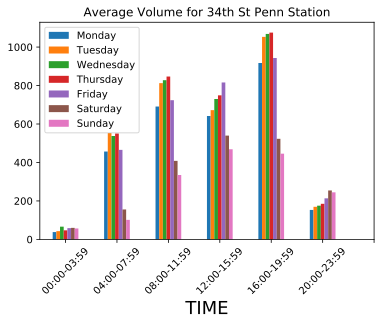

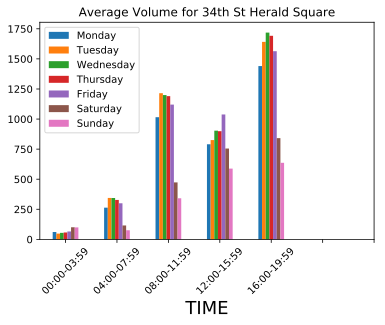

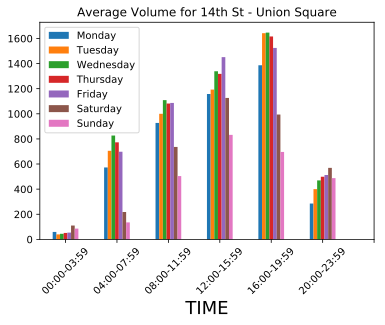

In [160]:
# mean_entries_exits = mta190504.groupby(['STATION', 'DDAY','time_cat'])['entries+exits'].mean()
# mean_entries_exits['59 ST']
# D1 = y.to_frame().reset_index()
# D1.head(10)

def graph_convert(D1,Station):
    day_dict = {}

    days = D1['DDAY'].unique()
    for day in days:
        day_dict[day] =  D1[D1['DDAY'] == day]['entries+exits'].values

    times = D1['time_cat'].unique()


    Final_df = pd.DataFrame({'time':times, 'Monday':day_dict['Monday'], 
                                'Tuesday':day_dict['Tuesday'], 
                                'Wednesday':day_dict['Wednesday'],'Thursday':day_dict['Thursday'],'Friday':day_dict['Friday'],'Saturday':day_dict['Saturday'],'Sunday':day_dict['Sunday']})
    Final_df

    Final_df[['time', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday',
           'Sunday']].plot(kind='bar')
    plt.xlabel('TIME', fontsize=18);
    plt.title("Average Volume for "+Station)
    plt.xticks([i for i in range(Final_df.shape[1]-1)], labels = Final_df['time'], rotation = 45);
    return 

graph_convert(mta_GC42_3,"42 St - Grand Central")
graph_convert(mta_34PE_3,"34th St Penn Station")
graph_convert(mta_34HE_3,"34th St Herald Square")
graph_convert(mta_14UN_3,"14th St - Union Square")
graph_convert(mta_23ST_3,"23 St")

In [161]:
mta_23ST_3

,STATION,DDAY,time_cat,entries+exits


In [ ]:
mta19.loc[(mta19["STATION"] == "23 ST") & (mta19["DDAY"] == "Saturday") & (mta19["time_cat"] == "20:00-23:59")].sort_values("entries+exits", ascending = False)